In [313]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
from scipy.stats import norm, laplace

In [192]:
path = './20190918_175317'
FEATURE_TYPE = 'hand_right_keypoints_2d'

In [411]:
# Data about the patient
SEX = {'M' : 0.3, 'F' : 0.2}

def age(a):
    if a > 50 and a <=70:
        return 0.7
    if a > 70:
        return 0.9
    return 0.2

In [193]:
def get_coords(path, feature_type):
    features = []
#     k = 0
    for file in os.listdir(path):
        f = '/'.join([path, file])

        with open(f, "r") as read_file:
            data = json.load(read_file)['people']
#             k += 1
#             if (len(data) == 2):
#                 print(len(data))
            for i, person in enumerate(data):
                if i == 1:
                    break
                arr = np.array(person[feature_type])
                features.append(arr)
    return features

In [194]:
def norm_coord(features):
    features = np.array(features).T
    #нормализация относительно 0-й точки ладони (непонятно лучше ли так будет работать, но вроде как лучше, не проверяли)
#     features[::3] = features[::3] - features[0]
#     features[1::3] = features[1::3] - features[1]
    return features[2:]

In [195]:
def max_subarray(arr):
    st = end = None
    l = 0
    max_st = max_end = None
    max_l = 0
#     print(arr)
    for i in range(len(arr)):
        if arr[i]:
            if not st:
                st = i
            l += 1
            end = i + 1
        if l > max_l:
            max_st = st
            max_end = end
            max_l = l
        if not arr[i]:
            l = 0
            st = end = None
    return max_st, max_end

In [196]:
def ts_cut(time_series, window_size=32.5):
    N = len(time_series)
    win_size = window_size
    step = int(win_size / 2)
    stds = []
    iter_num = int((N-win_size)/step+1)
    for i in range(iter_num):
        window = signal.detrend(time_series[step*i:step*(i+1)])
    #     print(window)
    
# detrended = signal.detrend(features[i*3+j][100:150])
        stds.append(np.std(window))
    stds = np.array(stds)
    med = np.mean(stds)
    q1 = np.percentile(stds, 25)
    q3 = np.percentile(stds, 75)
    st, end = max_subarray(stds >= med)
#     print(time_series[step*st:step*end])
#     plt.plot(time_series[step*st:step*end])
    return signal.detrend(time_series[step*st:step*end])

In [149]:
def zero_fill(arr):
    x = np.arange(len(arr))
    arr_no_0 = arr[arr!=0]
    interp = interp1d(x[arr!=0], arr_no_0, fill_value="extrapolate")
    fill = interp(x[arr==0])
    arr[arr==0] = fill
    return arr

In [393]:
def freq_get(ts, s_rate=1/32.5):
#     for j, axis in enumerate(['X', 'Y']):
#         freq = np.fft.fftfreq(len(ts[j]), d=s_rate)
#         fourie_decomp = np.abs(np.fft.fft(ts[j]).real)
    freq = np.fft.fftfreq(len(ts), d=s_rate)
    fourie_decomp = np.abs(np.fft.fft(ts).real)
    return freq, fourie_decomp    
#         print(axis, ':', freq[np.argsort(fourie_decomp.real)][:5])
#         print(fourie_decomp.real)
#         [plt.plot([freq[i], freq[i]], [min(fourie_decomp.real[i], 0), max(0, fourie_decomp.real[i])], color='b') 
#          for i in range(len(freq))]
# #         plt.ylim(-500, 500)
#         plt.show()

In [406]:
# plt.plot(freq, four_d)
# plt.plot(four_d)
def get_prob(freq, four_d):
    mu = 0
    sorted_four_d = np.sort(four_d)
    div_four_d = (sorted_four_d - np.roll(sorted_four_d, 1))
    [plt.plot([freq[i], freq[i]], [0, four_d[i] / simps(four_d)], color='b')
     for i in range(len(freq))]
#     print(div_four_d, np.mean(div_four_d[1:]), np.median(div_four_d[1:]))
    std = sorted_four_d[div_four_d>np.median(div_four_d[1:])][0]
    std = np.abs(freq[four_d==std])[0]
#     print(mu, std)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p / simps(p), 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()
#     print(simps(p[x>2] / simps(p)))
    return 2 * simps(four_d[freq>2] / simps(four_d)) /\
            (simps(p[x>2] / simps(p)) + simps(four_d[freq>2] / simps(four_d)))

In [412]:
def final_result(res, sex, a):
    return SEX[sex] * age(a) * np.mean(res)

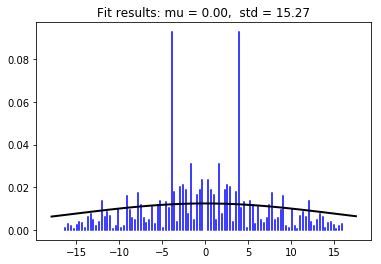

0.993200286987543


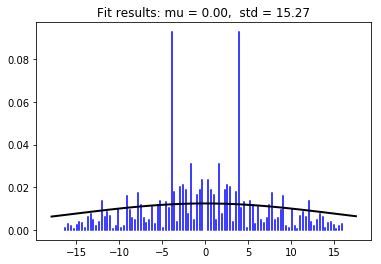

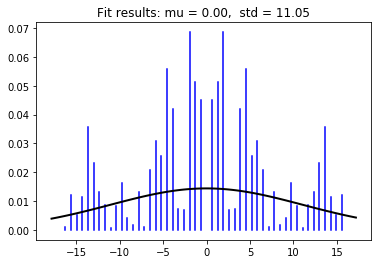

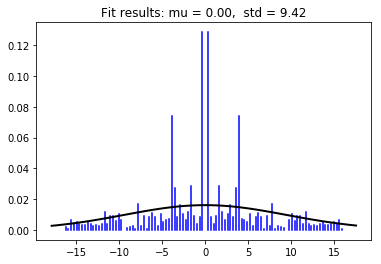

0.9546962149674727


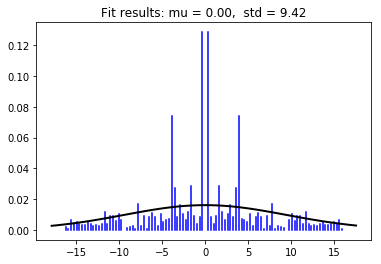

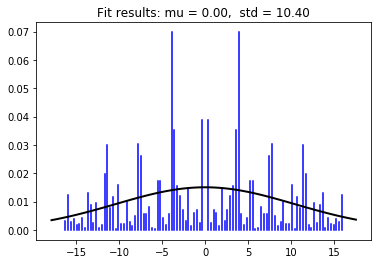

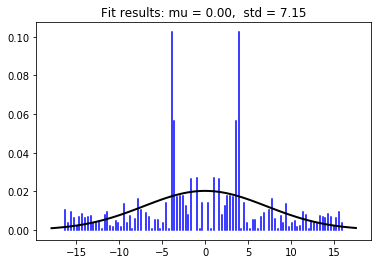

1.0647598594498213


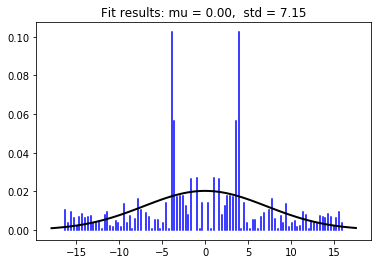

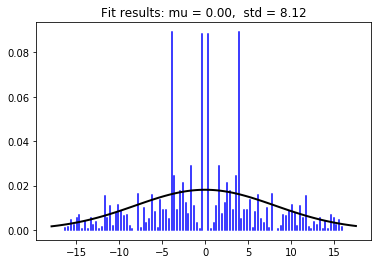

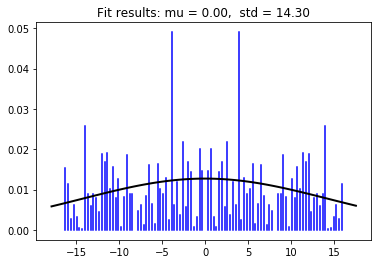

1.0048671540629168


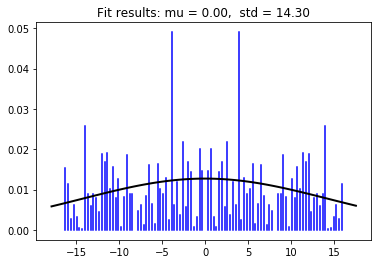

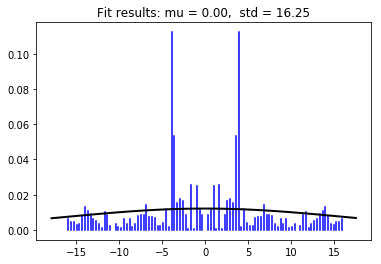

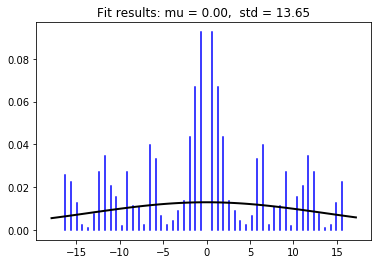

0.7976161696297024


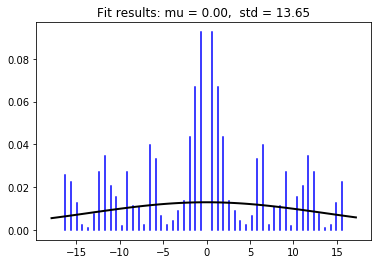

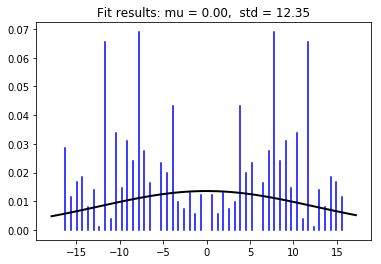

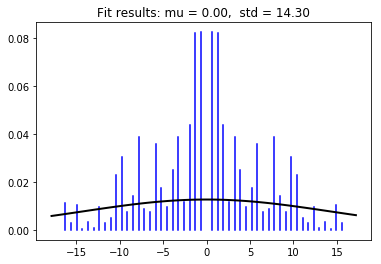

0.8551034091692876


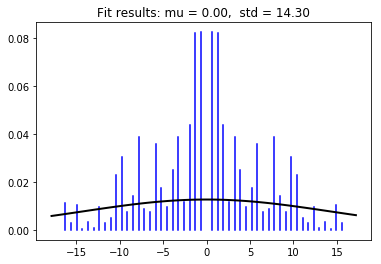

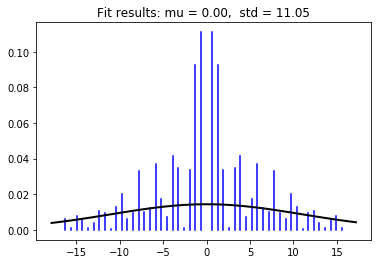

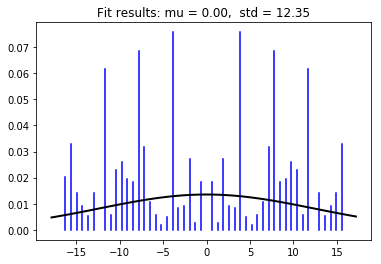

0.9438263207842392


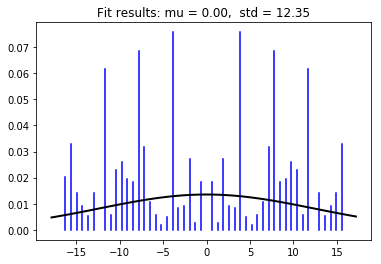

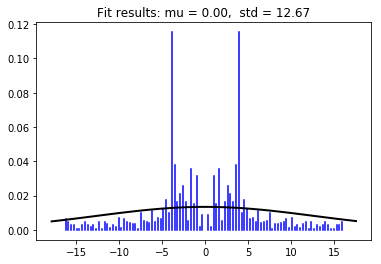

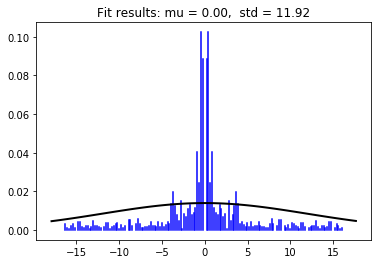

0.6821912593506456


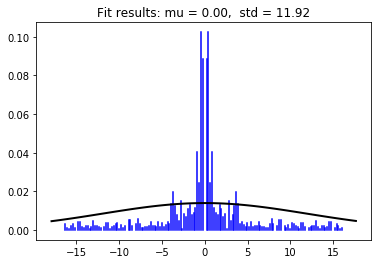

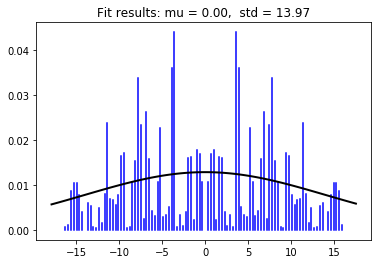

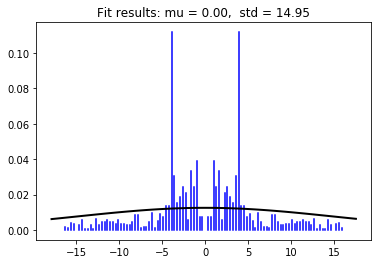

0.9709045945891779


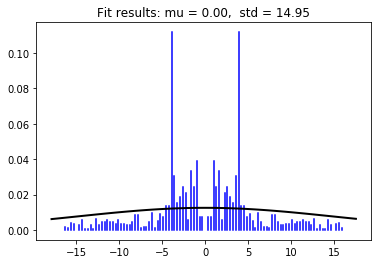

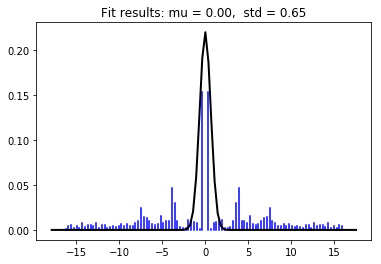

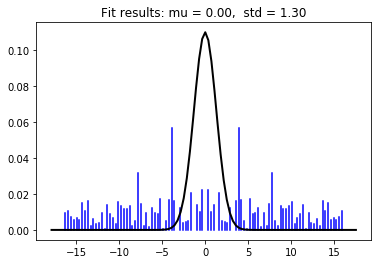

1.79741078281131


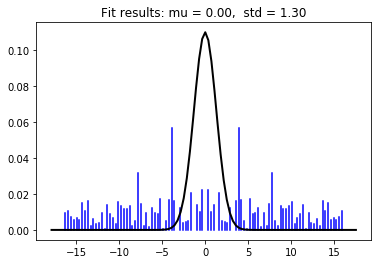

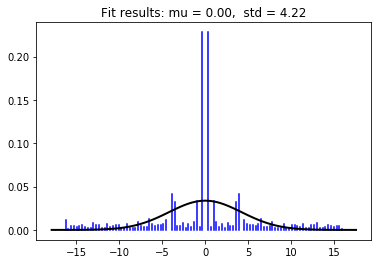

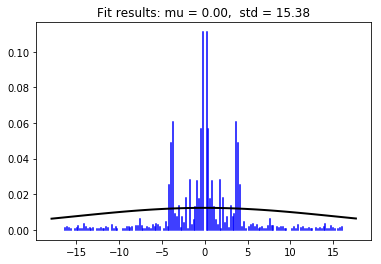

0.7565812131186329


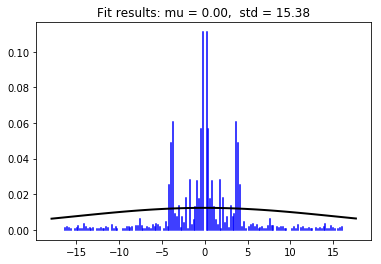

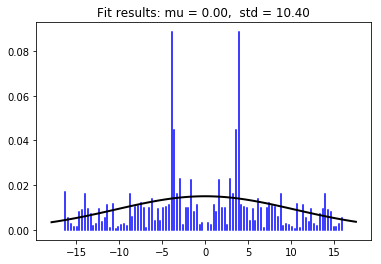

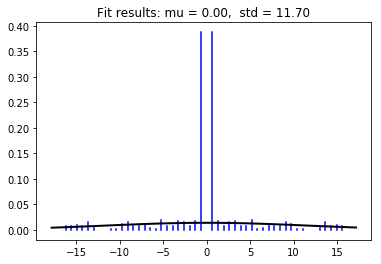

0.5907290834275863


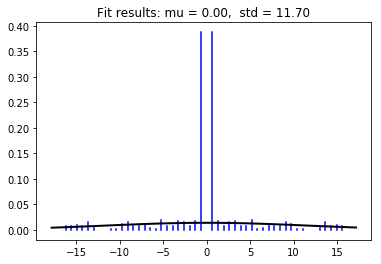

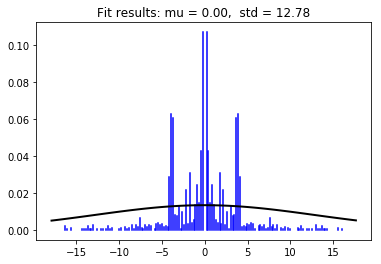

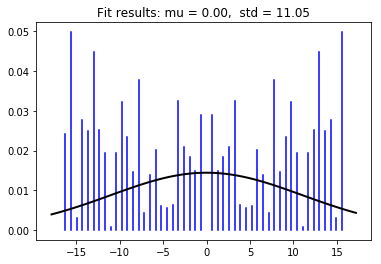

0.9631280084744173


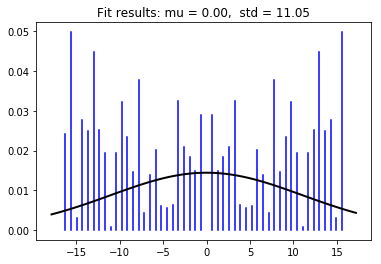

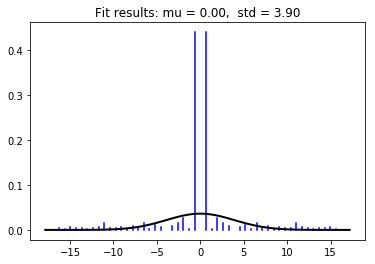

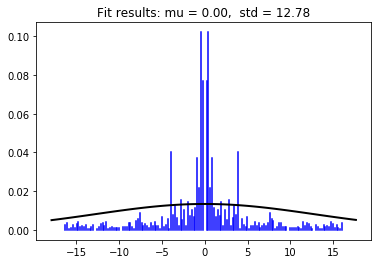

0.6891624574534222


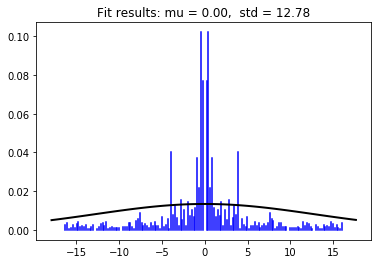

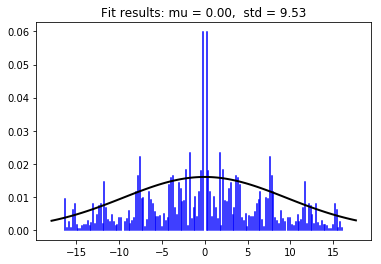

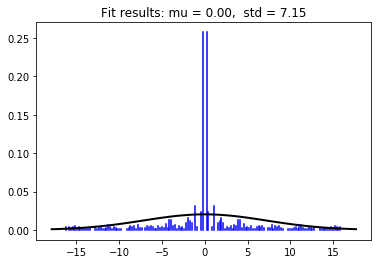

0.6917496581532084


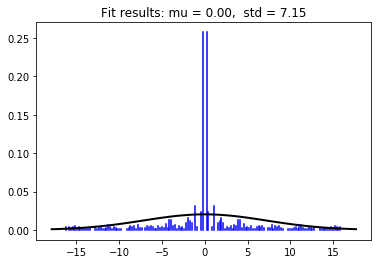

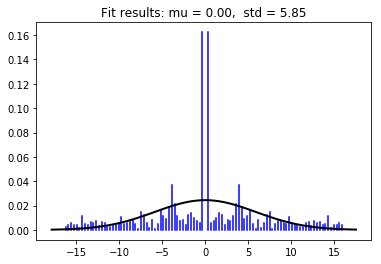

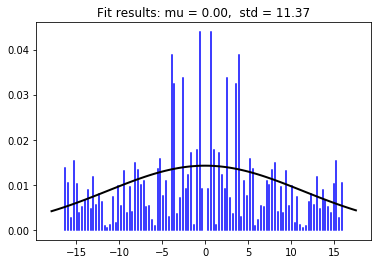

0.9663377640777558


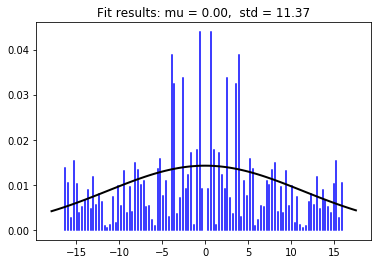

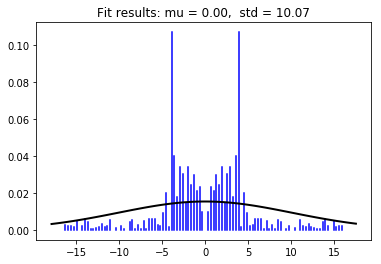

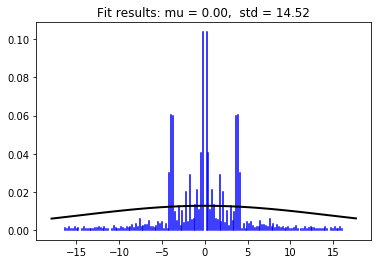

0.8057393309417958


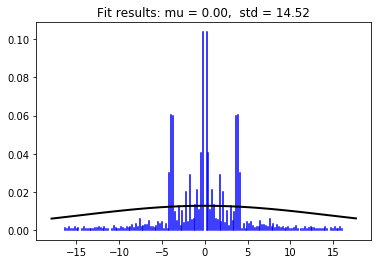

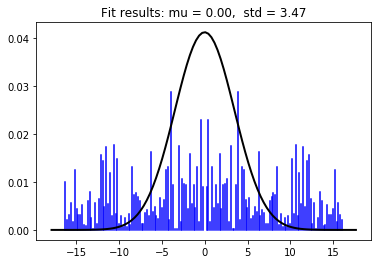

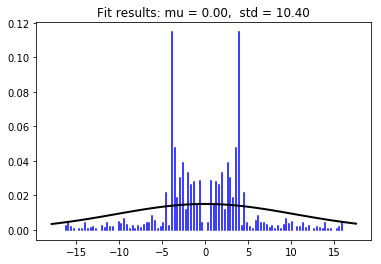

0.9758084295792363


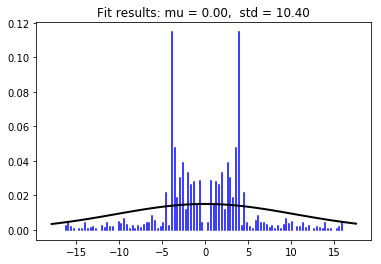

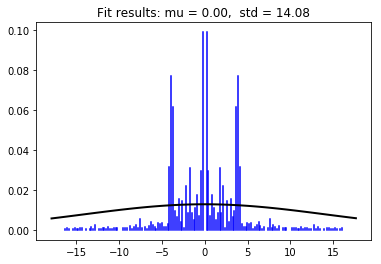

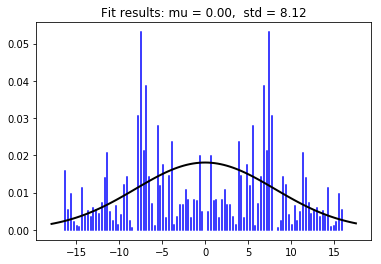

1.0350740701103731


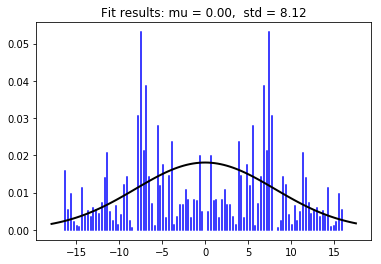

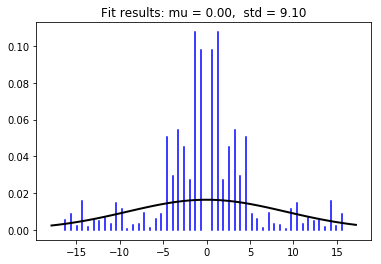

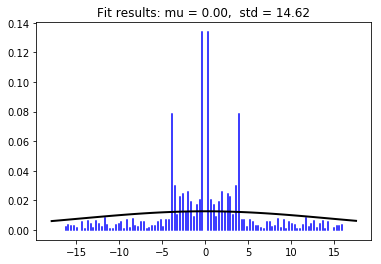

0.8737497807268999


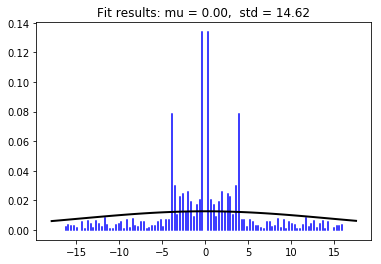

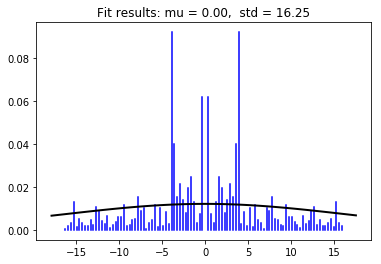

In [409]:
features = get_coords(path, FEATURE_TYPE)
num_of_points = len(features[0]) // 3
num_of_ims = len(features)
features = norm_coord(features)
cut_features = []
prob_X = []
prob_Y = []
for i in range(num_of_points-1): #не рассм точку, относительно которой нормировали
    feat_of_point_X = features[2*i,:]
    feat_of_point_Y = features[2*i+1,:]
#     conf = features[2*i+2,:]
#     print(conf)
#     cut_features.append(ts_cut(feat_of_point))
    cut_X = ts_cut(feat_of_point_X, window_size=100)
    cut_Y = ts_cut(feat_of_point_Y, window_size=100)
    freq_X, four_d_X = freq_get(cut_X)
    freq_Y, four_d_Y = freq_get(cut_Y)
#     freq, four_d = freq_get([feat_of_point_X, feat_of_point_Y])
    print(get_prob(freq_X, four_d_X))
    prob_X.append(get_prob(freq_X, four_d_X))
    prob_Y.append(get_prob(freq_Y, four_d_Y))
    
#     print(get_prob(freq, four_d))
res = (np.mean(prob_X), np.mean(prob_Y))

In [414]:
final_result(res, 'M', 22)

0.0765613455439909